# MTA Analysis

In [1]:
from __future__ import print_function, division

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

%matplotlib inline

## Read In Data

In [41]:
col_names = {'ENTRIES':int,'EXITS':int}

turnstiles_df = pd.read_csv('Turnstile_Usage_Data__2017.csv',dtype=col_names)
turnstiles_df.columns = [column.strip().upper() for column in turnstiles_df.columns]

In [42]:
turnstiles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8878203 entries, 0 to 8878202
Data columns (total 11 columns):
C/A            object
UNIT           object
SCP            object
STATION        object
LINE NAME      object
DIVISION       object
DATE           object
TIME           object
DESCRIPTION    object
ENTRIES        int64
EXITS          int64
dtypes: int64(2), object(9)
memory usage: 745.1+ MB


## Prep Data for analysis

label recover audits vs normal audits

group data

fix out of order turnstiles

In [3]:
#convert date and time to datetime
turnstiles_df["DATE_TIME"] = pd.to_datetime(turnstiles_df.DATE + " " + turnstiles_df.TIME, format="%m/%d/%Y %H:%M:%S")

In [4]:
#weekday
turnstiles_df['WEEKDAY'] = np.where(turnstiles_df['DATE_TIME'].dt.dayofweek >=5,0,1)

#day or night
turnstiles_df['DAY'] = np.where((turnstiles_df['DATE_TIME'].dt.hour > 4) & 
                                (turnstiles_df['DATE_TIME'].dt.hour <= 19),1,0)

turnstiles_df['NIGHT'] = np.where(turnstiles_df['DAY']==1,0,1)

#seasons
turnstiles_df['SPRING'] = np.where(turnstiles_df['DATE_TIME'].dt.month.isin([4,5,6]),1,0)
turnstiles_df['SUMMER'] = np.where(turnstiles_df['DATE_TIME'].dt.month.isin([7,8,9]),1,0)
turnstiles_df['FALL'] = np.where(turnstiles_df['DATE_TIME'].dt.month.isin([10,11,12]),1,0)
turnstiles_df['WINTER'] = np.where(turnstiles_df['DATE_TIME'].dt.month.isin([1,2,3]),1,0)

#number of lines

turnstiles_df['NUM_LINES'] = turnstiles_df['LINE NAME'].apply(lambda x: len(x))

In [5]:
#turn the DESC var into useful feature
turnstiles_df['BROKEN_AUDIT'] = np.where(turnstiles_df['DESCRIPTION']!='REGULAR',1,0)
turnstiles_df['BROKEN_AUDIT_DAY'] = (turnstiles_df.groupby(["C/A",
                                                            "UNIT",
                                                            "SCP",
                                                            "STATION",
                                                            "DATE"])["BROKEN_AUDIT"].transform("max"))

#remove duplicate audits
turnstiles_df.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True, ascending=False)
turnstiles_df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)

In [6]:
f = {
    
    'BROKEN_AUDIT_DAY':'first',
    'ENTRIES':'first',
    'EXITS':'first',
    'WEEKDAY':'first',
    'DAY':'mean', 
    'NIGHT':'mean', 
    'SPRING':'first', 
    'SUMMER':'first', 
    'FALL':'first', 
    'WINTER':'first',
    'NUM_LINES':'first'
    
}

#flatten the file
turnstiles_daily = turnstiles_df.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"]).agg(f).reset_index()

#shift the columns
turnstiles_daily[["PREV_DATE",
                  "PREV_ENTRIES",
                  "PREV_EXITS"]] = (turnstiles_daily
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", 
                                                                                                   "ENTRIES",
                                                                                                   "EXITS"]
                                                       .transform(lambda grp: grp.shift(1)))

# Drop the rows for last date
turnstiles_daily.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

In [7]:
def get_daily_entries(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        counter = -counter
    if counter > max_counter:
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
        return 0
    return counter

def get_daily_exits(row, max_counter):
    counter = row["EXITS"] - row["PREV_EXITS"]
    if counter < 0:
        counter = -counter
    if counter > max_counter:
        counter = min(row["EXITS"], row["PREV_EXITS"])
    if counter > max_counter:
        return 0
    return counter

turnstiles_daily["DAILY_ENTRIES"] = turnstiles_daily.apply(get_daily_entries, axis=1, max_counter=1000000)

turnstiles_daily["DAILY_EXITS"] = turnstiles_daily.apply(get_daily_exits, axis=1, max_counter=1000000)

In [95]:
turnstiles_daily_use = turnstiles_daily.loc[:,[
    
    'C/A',
    'UNIT',
    'SCP',
    'STATION',
    'DATE',
    'DAILY_ENTRIES',
    'DAILY_EXITS',
    'WEEKDAY', 
    'DAY', 
    'NIGHT', 
    'SPRING', 
    'SUMMER', 
    'FALL',
    'WINTER', 
    'NUM_LINES',
    'BROKEN_AUDIT_DAY'
]]

turnstiles_daily_use = turnstiles_daily_use[turnstiles_daily_use['DATE']!='12/31/2016']

In [10]:
turnstiles_daily_use.to_csv('clean_MTA_data.csv', index = True)

In [11]:
import seaborn as sns

In [27]:
dates_use = turnstiles_daily_use['DATE'].unique()[0:len(turnstiles_daily_use['DATE'].unique())//8]

turnstiles_daily_samp = turnstiles_daily_use[turnstiles_daily_use['DATE'].isin(dates_use)]

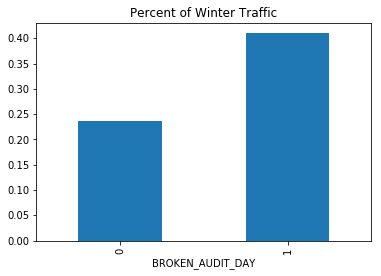

In [96]:
_ = turnstiles_daily_use.groupby('BROKEN_AUDIT_DAY').mean()[['WINTER']].plot(kind = 'bar',
                                                                         legend = False,
                                                                         title = 'Percent of Winter Traffic',
                                                                         )

Text(0,0.5,'Percent of Weekday Traffic')

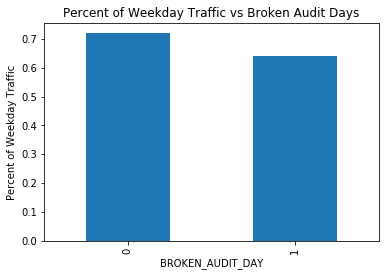

In [97]:
_ = turnstiles_daily_use.groupby('BROKEN_AUDIT_DAY').mean()[['WEEKDAY']].plot(kind = 'bar',
                                                                         legend = False,
                                                                         title = 'Percent of Weekday Traffic vs Broken Audit Days',
                                                                         )

plt.ylabel('Percent of Weekday Traffic')

Text(0,0.5,'Number of Lines Served')

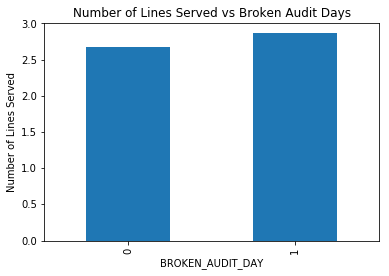

In [125]:
_ = turnstiles_daily_use.groupby('BROKEN_AUDIT_DAY').mean()[['NUM_LINES']].plot(kind = 'bar',
                                                                         legend = False,
                                                                         title = 'Number of Lines Served vs Broken Audit Days',
                                                                         )

plt.ylabel('Number of Lines Served')

In [122]:
turnstiles_daily_use.groupby('STATION').sum()

,DAILY_ENTRIES,DAILY_EXITS,WEEKDAY,DAY,NIGHT,SPRING,SUMMER,FALL,WINTER,NUM_LINES,BROKEN_AUDIT_DAY
STATION,,,,,,,,,,,
1 AV,6973986.0,8020105.0,2250,1742.834957,1387.165043,770,850,760,750,3130,80
103 ST,10225940.0,7095456.0,3368,2878.485714,1808.514286,1154,1275,1140,1118,5626,151
103 ST-CORONA,6388679.0,4791037.0,2025,1567.109524,1249.890476,693,765,684,675,2817,18
104 ST,1057722.0,339897.0,2015,1553.351190,1251.648810,685,761,684,675,4049,22
110 ST,3683850.0,2898674.0,1350,1048.558333,829.441667,462,510,456,450,1878,48
111 ST,5730045.0,3417823.0,3600,2913.989610,2094.010390,1232,1360,1216,1200,5008,66
116 ST,10959814.0,6459492.0,4950,4236.021634,2649.978366,1694,1870,1672,1650,11268,130
116 ST-COLUMBIA,4542882.0,2315699.0,1350,1156.350000,721.650000,462,510,456,450,1878,24
121 ST,369811.0,264264.0,1028,811.273810,616.726190,308,348,380,392,2856,14


Text(0,0.5,'Broken Audit Instances')

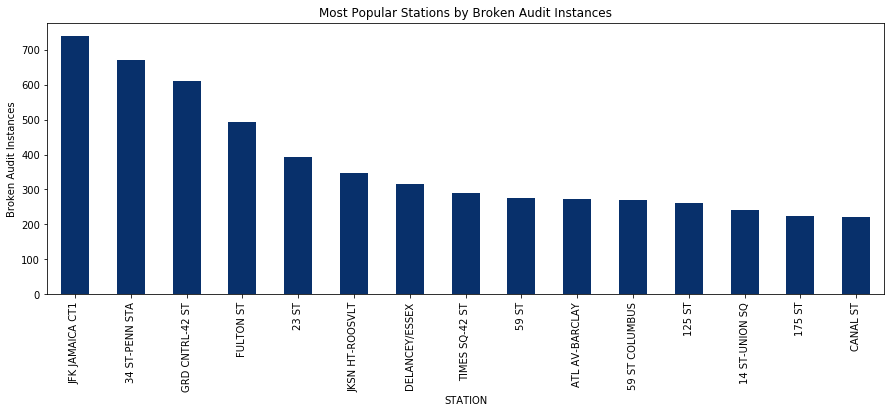

In [124]:
turnstiles_daily_use.groupby('STATION').sum().sort_values('BROKEN_AUDIT_DAY',
                                ascending = False).head(15)['BROKEN_AUDIT_DAY'].plot(kind = 'Bar',
                                                                                 figsize = (15,5),
                                                                                 colormap = 'Blues_r',
                                                                                title = 'Most Popular Stations by Broken Audit Instances'
                                                                                 )

plt.ylabel('Broken Audit Instances')

Text(0,0.5,'Daily Entries')

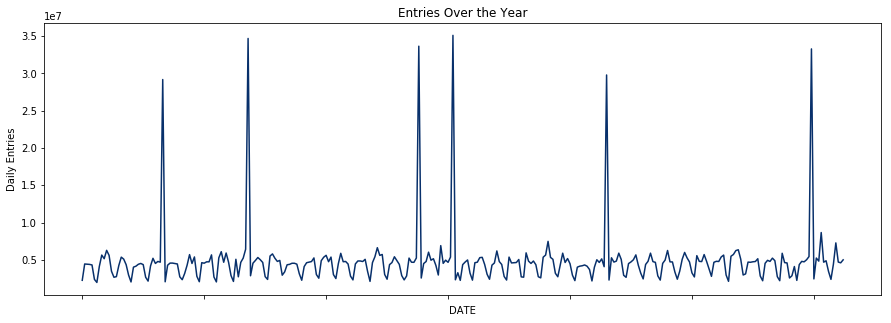

In [105]:
turnstiles_daily_use.groupby('DATE').sum()['DAILY_EXITS'].plot(kind = 'Line',
                                                                                 figsize = (15,5),
                                                                                 colormap = 'Blues_r',
                                                                                title = 'Entries Over the Year'
                                                                                 )

plt.ylabel('Daily Entries')

Text(0,0.5,'Daily Entries')

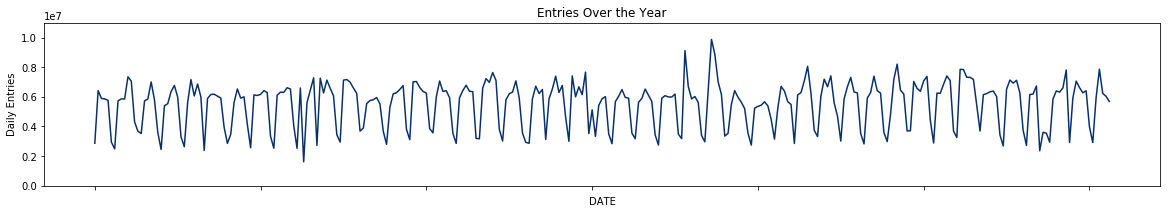

In [116]:
bump_chart = turnstiles_daily_use.groupby('DATE').sum()

bump_chart[bump_chart['DAILY_ENTRIES']<10000000]['DAILY_ENTRIES'].plot(kind = 'Line',
                                                                                 figsize = (20,3),
                                                                                 colormap = 'Blues_r',
                                                                                title = 'Entries Over the Year',
                                                                       ylim = (0,11000000)
                                                                                 )

plt.ylabel('Daily Entries')

Text(0,0.5,'Broken Audit Instances')

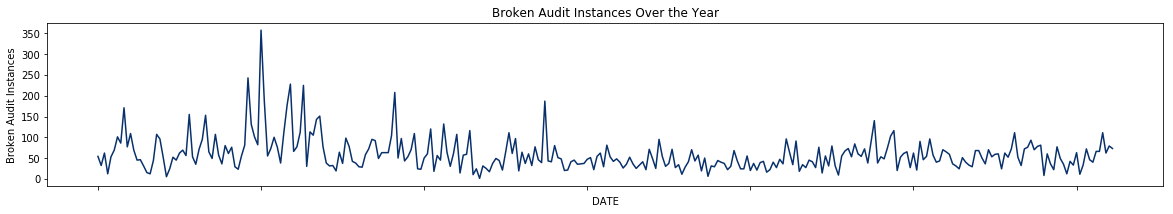

In [120]:
bump_chart = turnstiles_daily_use.groupby('DATE').sum()

bump_chart[bump_chart['BROKEN_AUDIT_DAY']<1000]['BROKEN_AUDIT_DAY'].plot(kind = 'Line',
                                                                                 figsize = (20,3),
                                                                                 colormap = 'Blues_r',
                                                                                title = 'Broken Audit Instances Over the Year',
                                                                       #ylim = (0,11000000)
                                                                                 )

plt.ylabel('Broken Audit Instances')

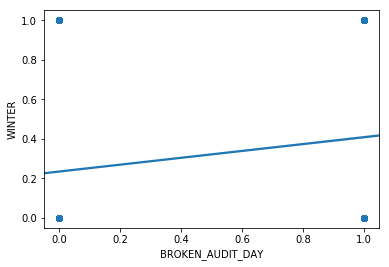

In [39]:
sns.regplot("BROKEN_AUDIT_DAY", "WINTER", fit_reg = True, data=turnstiles_daily_use)